In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.preprocessing as skp
# import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Basic Code
This part can be ignored, it serves to build the technical process to develop the actual model, but doesn't contain too much to interpret from a model evaluation point of view

In [2]:
#Creates Lagged series
#Goes through a series and generates an lag+1 dimensional pandas DataFrame that has each previous lag timeunit
#as a column and current as the last cobilumn
#Input: Pandas Series
#Output: lag+1 dimensional DataFrame

def timeseriesLagged(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+2)] 
    df = pd.concat(columns,axis=1)
    df.fillna(0, inplace=True)
    df.columns = [str(lag+2-x) for x in range(1,lag+2)]
    # df.reset_index(inplace=True,drop=False)
    df = df[df.columns[::-1]] #Flip because we want newer data on the right
    df= df.iloc[lag+1:] # drop the first 'lag' columns because zeroes.
    df.reset_index(drop=True,inplace=True)
    return df

# Binarizes the last column into 1, 0, -1. 1 = buy 0 = do nothing -1 = sell
# Rate is the percent increase or decrease that should trigger a buy or a sell
# lag is the time unit of lag. 
# atleast is how many of the lookahead need to be atleast the same or greater than flat+rat
# Input: lagged pandas DataFrame, uint lag, double dif, double flat, double atleast between 0 and 1
# Output : Pandas Dataframe with last column binarized
def binarizeTime(resLagged,rate = 0,lookahead = 0, flat = 0,atleast = 0.5):
    if lookahead <= 0 :
        raise Exception("lookahead Must be 1 or higher!")
    resLagged = resLagged.copy() # Make a deep copy
    last = np.shape(resLagged)[1] # find the length of the data 
    last = last-lookahead # convert it to string for loc
    colsLookAhead = list(resLagged.loc[:,str(last+1):str(last + lookahead)])
    colsLast = resLagged[str(last)]
    diffs = resLagged[colsLookAhead].subtract(colsLast,axis=0)
#     print(diffs)
    greater = diffs>=flat  # all the times the price changed higer than flat
    greater = np.count_nonzero(greater,axis=1).reshape((1,-1))
    lesser = diffs<=-flat # all the times the price fell lower than fat
    lesser = np.count_nonzero(lesser,axis=1).reshape((1,-1))
#     return greater,lesser
#     print(greater)
    greater = greater.reshape(1,-1)
    changeToBuy = np.any(greater > lesser & np.greater(greater,atleast*lookahead),axis=0) # make sure more rises than falls and atleast half rises
    changeToSell = np.any(lesser > greater & np.greater(lesser,atleast*lookahead),axis=0)      # make sure more falls than rises and atleast half rises
    changeToHold = ~changeToBuy & ~changeToSell
    resLagged = resLagged.drop(colsLookAhead,1)
    resLagged.loc[changeToSell,str(last+1)] = -1 # Set sell to -1
    resLagged.loc[changeToBuy,str(last+1)] = 1 # Set buy to 1
    resLagged.loc[changeToHold,str(last+1)] = 0 # Set to 0
    return resLagged

In [7]:
# Nifty. Reading and Cleaning
h = 5
fut = pd.read_csv("Nifty50FUT.csv")
fut['Price']= fut['Price'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Open']= fut['Open'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['High']= fut['High'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Low']= fut['Low'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Vol.']= fut['Vol.'].str.replace(",","").str.replace("M","e6").str.replace("-","0").str.replace("K","e3").astype(np.double).rolling(h).mean()
fut = fut[::-1]
fut.reset_index(inplace=True, drop = True)

nifty = pd.read_csv("Nifty.csv")
nifty = nifty[::-1]
nifty.reset_index(inplace=True, drop = True)
nifty['Price']= nifty['Price'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Open']= nifty['Open'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['High']= nifty['High'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Low']= nifty['Low'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Vol.']= nifty['Vol.'].str.replace(",","").str.replace("M","e6").str.replace("-","0").str.replace("K","e3").astype(np.double).rolling(h).mean()


niftyDrop = np.setdiff1d(fut['Date'].values,nifty['Date'].values)
futDrop = np.setdiff1d(nifty['Date'].values,fut['Date'].values)
nifty = nifty[~nifty.Date.isin(futDrop)]
fut = fut[~fut.Date.isin(niftyDrop)]

In [11]:
fut['Price']

0              NaN
1              NaN
2              NaN
3        6237.6750
4        6250.8500
5        6272.4000
6        6246.5125
7        6225.3500
8        6213.3375
9        6165.0875
10       6111.8500
11       6043.8875
12       5920.2875
13       5701.9000
14       5438.6375
15       5247.4250
16       5066.1500
17       5114.1625
18       5208.0250
19       5235.8375
20       5273.7125
21       5210.6000
22       5223.2875
23       5267.4750
24       5348.5250
25       5388.3500
26       5333.1500
27       5241.9625
28       5074.3625
29       4949.0125
           ...    
2713    11019.1000
2714    11059.9500
2715    11100.6625
2716    11136.2750
2717    11188.1000
2718    11237.2250
2719    11296.0250
2720    11347.7750
2721    11341.6750
2722    11355.9875
2723    11366.6500
2724    11377.6625
2725    11424.0000
2726    11446.9500
2727    11453.2000
2728    11443.9000
2729    11442.8500
2731    11423.6875
2732    11435.9875
2733    11485.4375
2734    11516.2125
2736    1156

In [4]:
# Nifty Base
volNifty = nifty['Vol.'].diff().dropna()
openNifty = nifty['Open'].diff().dropna()
highNifty = nifty['High'].diff().dropna()
lowNifty = nifty['Low'].diff().dropna()
dataNifty = nifty['Price'].diff().dropna()

# Nifty Futs
volFut = fut['Vol.'].diff().dropna()
openFut = fut['Open'].diff().dropna()
highFut = fut['High'].diff().dropna()
lowFut = fut['Low'].diff().dropna()
dataFut = fut['Price'].diff().dropna()
#Future Premium
prems = dataFut.values - dataNifty.values
prems = pd.Series(prems)

In [288]:
lag=15
lookahead = 1
flat = 0
# First N predicts N+1th. Creating the 1st N series
closeNifty = timeseriesLagged(dataNifty,lag + lookahead-1)
# These are correlated with closeNifty, so we will ignore them for now
# openNifty = timeseriesLagged(openNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# highNifty = timeseriesLagged(highNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# lowNifty = timeseriesLagged(lowNifty,lag + lookahead-1).drop(str(lag+1),axis=1)

volNifty = timeseriesLagged(volNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
volNifty = skp.minmax_scale(volNifty,axis=1)

# First N predicts N+1th. Creating the 1st N series
closeFut = timeseriesLagged(dataFut,lag + lookahead-1).drop(str(lag+1),axis=1)
closeFut = skp.minmax_scale(closeFut,axis=1)

# These are correlated with closeNifty, so we will ignore them for now
# openNifty = timeseriesLagged(openNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# highNifty = timeseriesLagged(highNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# lowNifty = timeseriesLagged(lowNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
volFut = timeseriesLagged(volFut,lag + lookahead-1).drop(str(lag+1),axis=1)
volFut = skp.minmax_scale(volFut,axis=1)

prems = timeseriesLagged(prems,lag + lookahead-1).drop(str(lag+1),axis=1)
prems = skp.minmax_scale(prems,axis=1)





In [289]:
closeNifty.loc[closeNifty[str(lag+1)] > flat,str(lag+1)] = 1
closeNifty.loc[closeNifty[str(lag+1)] <= flat,str(lag+1)] = 2
closeNifty.loc[closeNifty[str(lag+1)] == flat,str(lag+1)] = 3


In [290]:
n = 5
buySeriesLabs = closeNifty[str(lag+1)] # labels
buySeriesFeats = closeNifty.drop(str(lag+1),axis=1) #features
buySeriesFeats = buySeriesFeats.values
buySeriesFeats = skp.scale(buySeriesFeats,axis=1)

buySeries = np.zeros((len(buySeriesFeats),buySeriesFeats.shape[-1],n))
buySeries[:,:,0] = buySeriesFeats
buySeries[:,:,1] = volFut
buySeries[:,:,2] = prems
buySeries[:,:,3] = closeFut
buySeries[:,:,4] = volNifty



In [291]:
x,y = buySeries,buySeriesLabs
x,y = shuffle(x,y)
tot = len(x)
y = y.values
yOrig = np.copy(y)

x = x.reshape(len(x),-1)
trainPercent = 0.9 # majority of data used for training
testPercent = 0.9 # 
valPercent = 1.00  #

# Test Train Val Split

xTrain = x[0:int(trainPercent*tot),:]
yTrain = y[0:int(trainPercent*tot)]

xTest = x[int(trainPercent*tot): int(testPercent*tot),:]
yTest = y[int(trainPercent*tot): int(testPercent*tot)]

xVal = x[int(testPercent*tot):,:]
yVal = y[int(testPercent*tot):]

In [292]:
clf = svm.SVC(kernel='rbf')
clf.fit(xTrain, yTrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [293]:
preds = clf.predict(xVal)
print(sum(preds==yVal)/len(yVal))
print(confusion_matrix(yVal,preds))

0.4866920152091255
[[89 44]
 [91 39]]


# Actual Dataset
We will try to use Open Interest, Volume, Price from Nifty Futures and Price and Volume from Nifty from the last $LAG$ (variable, will adjust as fit) to make a prediction on whether nifty will increase or decrease as compared to $h$ days ago.

In [3]:
# Read all the data from the csv files
nifty = pd.read_csv("NiftyPrice.csv")
nifty = nifty[::-1] # Reverse to align
nifty.reset_index(inplace=True, drop = True)
nifty.rename(columns={ nifty.columns[0]: "Date" },inplace=True)

futOI = pd.read_csv("NiftyFutOI.csv")
futOI = futOI[::-1] # Reverse to align
futOI.reset_index(inplace=True, drop = True)
futOI.rename(columns={ futOI.columns[0]: "Date" },inplace=True)

fut = pd.read_csv("NiftyFutPrice.csv")
fut = fut[::-1] # reverse to align
fut.reset_index(inplace=True, drop = True)
fut.rename(columns={ fut.columns[0]: "Date" },inplace=True)

oil = pd.read_csv("oil.csv")
# oil = oil[::-1]
oil.reset_index(inplace=True, drop = True)
oil.rename(columns={ oil.columns[0]: "Date" },inplace=True)

usdinr = pd.read_csv("usdinr.csv")
usdinr.rename(columns={ usdinr.columns[0]: "Date" },inplace=True)

advances = pd.read_csv("advances.csv")
advances.rename(columns={ advances.columns[0]: "Date" },inplace=True)

declines = pd.read_csv("decline.csv")
declines.rename(columns={ declines.columns[0]: "Date" },inplace=True)
# Drop any rows not common in both
# Data Arrays
dat = [nifty,fut,futOI,oil,usdinr,advances,declines]

# Clean and make sure they have the same dates
dropset = [] # Collect the dropsets
n = 2
for cleanee in dat: # O(n^2)
    for cleaner in dat: 
        drop = np.setdiff1d(cleaner['Date'].values,cleanee['Date'].values) # Everything in cleaner AND not in cleanee
        dropset.append(drop)

for i in range(0,len(dat)): # Actuall drop
    for drop in dropset:
        dat[i] = dat[i][~dat[i].Date.isin(drop)]        


In [103]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc

In [54]:
# Create % change daily bars of the different features
# Nifty Base
h = 1 # change from how far ago
t = 5
t2 = 9
t4 = 15 
volNifty = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volNiftyt2 = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volNiftyt4 = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()
lowestVolNiftyIndex = min(volNiftyt4.index)

dataNifty = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataNiftyt2 = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t2).mean().dropna()
dataNiftyt4 = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()

# Nifty Futs
volFut = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volFutt2 = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volFutt4 = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()

oiFut = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t).mean().dropna()
oiFutt2 = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t2).mean().dropna()
oiFutt4 = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t4).mean().dropna()

dataFut = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataFutt2 = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t2).mean().dropna()
dataFutt4 = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()

# Oil
volOil = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volOilt2 = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volOilt4 = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()

dataOil = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataOilt2 = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()
dataOilt4 = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()


# USDINR
dataUSDINR = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t).mean().dropna()
dataUSDINRt2 = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t2).mean().dropna()
dataUSDINRt4 = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t4).mean().dropna()

# Advance Decline
advanceTot = dat[5]['PX_LAST'].rolling(h).mean()
declineTot = dat[6]['PX_LAST'].rolling(h).mean()
# advanceDecline = advanceDecline # drop the first row because we are dropping it in the others
advanceDecline = advanceTot/declineTot
advanceDecline = pd.Series(advanceDecline[t:])
# advanceDecline = advanceDecline.pct_change(h).dropna()*100

In [55]:
lag = 15
lookahead = 1
flat = 0
# First N predicts N+1th. Creating the 1st N series
closeNifty = timeseriesLagged(dataNifty,lag + lookahead-1)

volNifty = timeseriesLagged(volNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# volNifty = skp.scale(volNifty,axis=1)

# First N predicts N+1th. Creating the 1st N series
closeFut = timeseriesLagged(dataFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# closeFut = skp.scale(closeFut,axis=1)

volFut = timeseriesLagged(volFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# volFut = skp.scale(volFut,axis=1)

oiFut = timeseriesLagged(oiFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# oiFut = skp.scale(oiFut,axis=1)

# Oil
volOil = timeseriesLagged(volOil,lag + lookahead-1).drop(str(lag+1),axis=1)
# volOil = skp.scale(volOil,axis=1)
dataOil = timeseriesLagged(dataOil,lag + lookahead-1).drop(str(lag+1),axis=1)
# dataOil = skp.scale(dataOil,axis=1)

# USDINR
dataUSDINR = timeseriesLagged(dataUSDINR,lag + lookahead-1).drop(str(lag+1),axis=1)
# dataUSDINR = skp.scale(dataUSDINR,axis=1)


# Advance Decline
advanceDecline = timeseriesLagged(advanceDecline,lag + lookahead-1).drop(str(lag+1),axis=1)
advanceDecline = skp.scale(advanceDecline,axis=1)

In [56]:
# Binazrize the last column
toOne = closeNifty[str(lag+1)] > closeNifty[str(lag)]
toTwo = closeNifty[str(lag+1)] <= closeNifty[str(lag)]
closeNifty.loc[toOne,str(lag+1)] = 1
closeNifty.loc[toTwo,str(lag+1)] = 2
# closeNifty.loc[closeNifty[str(lag+1)] == closeNifty[str(lag)],str(lag+1)] = 3
closeNifty[str(lag+1)]=closeNifty[str(lag+1)].astype(np.int)

In [57]:
# Build the feature vector
n = 4
buySeriesLabs = closeNifty[str(lag+1)] # labels
buySeriesFeats = closeNifty.drop(str(lag+1),axis=1) #features
buySeriesFeats = buySeriesFeats.values
# buySeriesFeats = skp.scale(buySeriesFeats,axis=1)


buySeries = np.zeros((len(buySeriesFeats),buySeriesFeats.shape[-1],n))
buySeries[:,:,0] = buySeriesFeats
buySeries[:,:,1] = volFut
buySeries[:,:,2] = oiFut
# buySeries[:,:,3] = volOil
# buySeries[:,:,4] = dataOil
# buySeries[:,:,5] = dataUSDINR
buySeries[:,:,3] = advanceDecline

In [58]:
# Split into train test val
from sklearn.preprocessing import StandardScaler
x,y = buySeries,buySeriesLabs
x,y = shuffle(x,y)
tot = len(x)
y = y.values
yOrig = np.copy(y)

scaler = StandardScaler()  


x = x.reshape(len(x),-1)
trainPercent = 0.7 # majority of data used for training
testPercent = 0.7 # 
valPercent = 1.00  #

# Test Train Val Split

xTrain = x[0:int(trainPercent*tot),:]
yTrain = y[0:int(trainPercent*tot)]
scaler.fit(xTrain)

xTest = x[int(trainPercent*tot): int(testPercent*tot),:]
yTest = y[int(trainPercent*tot): int(testPercent*tot)]

xVal = x[int(testPercent*tot):,:]
yVal = y[int(testPercent*tot):]

# xTrain = scaler.transform(xTrain)  
# xTest = scaler.transform(xVal) 

In [59]:
# KNN
neigh = KNeighborsClassifier(n_neighbors=15, weights= 'distance')
neigh.fit(xTrain,yTrain)
preds = neigh.predict(xVal)


In [60]:
# predsArray = []
# accArray = []
# test = 500
# for i in range(100,test):
#     neigh = KNeighborsClassifier(n_neighbors=i)
#     neigh.fit(xTrain,yTrain)
#     pred = neigh.predict(xVal)
#     acc = sum(yVal==pred)/len(yVal)
#     predsArray.append(pred)
#     accArray.append(acc)
    
    

In [61]:
conf = confusion_matrix(yVal,preds)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))


TRUE NEGATIVE: 205
TRUE POSITIVE: 179
FALSE POSITIVE: 118
FALSE NEGATIVE: 125
Weight of Buy in data set: 0.515152


In [62]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))

Accuracy Percent: 0.612440
Precision of Buy Model= 0.602694
Recall of Buy Model = 0.588816


In [63]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Sell Model= %f" % (tn/(tn+fn)))
print("Recall of Sell Model = %f" % (tn/(tn+fp)))
print("Weight of Sell in data set: %f" % (sum(yVal==2)/len(yVal)))

Accuracy Percent: 0.612440
Precision of Sell Model= 0.621212
Recall of Sell Model = 0.634675
Weight of Sell in data set: 0.484848


In [64]:
# rbf SVM
clf = svm.SVC(kernel='linear', degree = 3, probability= True) # change kernels between linear, poly and rbf as fit.
clf.fit(xTrain, yTrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
# predsProbs = clf.predict_log_proba(xVal)
# np.argmax(predsProbs,axis=1)

In [66]:
predsProbs = clf.predict_proba(xVal)
preds = clf.predict(xVal)


In [67]:
# predsProbs
# predsProbs = predsProbs < 0.7

In [68]:
# predsProbs = predsProbs < 0.7
# preds = np.argmax(predsProbs,axis=1) +1

In [69]:
conf = confusion_matrix(yVal,preds)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))

TRUE NEGATIVE: 244
TRUE POSITIVE: 186
FALSE POSITIVE: 79
FALSE NEGATIVE: 118
Weight of Buy in data set: 0.515152


In [70]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))

Accuracy Percent: 0.685805
Precision of Buy Model= 0.701887
Recall of Buy Model = 0.611842


In [71]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Sell Model= %f" % (tn/(tn+fn)))
print("Recall of Sell Model = %f" % (tn/(tn+fp)))
print("Weight of Sell in data set: %f" % (sum(yVal==2)/len(yVal)))

Accuracy Percent: 0.685805
Precision of Sell Model= 0.674033
Recall of Sell Model = 0.755418
Weight of Sell in data set: 0.484848


In [92]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))

Accuracy Percent: 0.631579
Precision of Buy Model= 0.854369
Recall of Buy Model = 0.289474


In [162]:
y_score = clf.predict_proba(xVal)
y_score = y_score[:,1]

In [163]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yVal, y_score,pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

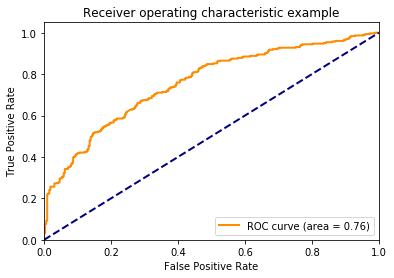

In [164]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()